# TP 2 : Branch-and-bound applied to a knapsack problem

### Initialisation (à faire une seule fois)

In [1]:
import Pkg; 
Pkg.add("GraphRecipes"); Pkg.add("Plots"); 
using GraphRecipes, Plots #only used to visualize the search tree at the end of the branch-and-bound

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...


  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`


   Resolving package versions...


  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`


### Récupération des données

In [2]:
function readKnaptxtInstance(filename)
    price=[]
    weight=[]
    KnapCap=[]
    open(filename) do f
        for i in 1:3
            tok = split(readline(f))
            if(tok[1] == "ListPrices=")
                for i in 2:(length(tok)-1)
                    push!(price,parse(Int64, tok[i]))
                end
            elseif(tok[1] == "ListWeights=")
                for i in 2:(length(tok)-1)
                    push!(weight,parse(Int64, tok[i]))
                end
            elseif(tok[1] == "Capacity=")
                push!(KnapCap, parse(Int64, tok[2]))
            else
                println("Unknown read :", tok)
            end 
        end
    end
    capacity=KnapCap[1]
    return price, weight, capacity
end

readKnaptxtInstance (generic function with 1 method)

### Tests de sondabilités TA, TO et TR basés sur le modèle linéaire

In [3]:
# function TestsSondabilite_LP(model2, x, BestProfit, Bestsol)
#     TA, TO, TR = false, false, false
#     if(termination_status(model2) == MOI.INFEASIBLE)#Test de faisabilite
#         TA=true
#         println("TA")
#     elseif(objective_value(model2) <= BestProfit) #Test d'optimalite
#         TO=true
#         println("TO")
#     elseif( prod(abs.([round.(v, digits=0) for v in value.(x)]-value.(x)) .<= fill(10^-5, size(x))) 
#         ) #Test de resolution
#         TR=true
#         println("TR")
#         #if (value(benef) >= BestProfit)
#         if (objective_value(model2) >= BestProfit)
#             Bestsol = value.(x)
#             #BestProfit=value(benef)
#             BestProfit=objective_value(model2)
#             println("\nNew Solution memorized ", Bestsol, " with bestprofit ", BestProfit, "\n")
#         end
#     else
#         println("non sondable")
#     end
#     TA, TO, TR, Bestsol, BestProfit
# end


function TestsSondabilite(listobjs, listvals, price, weight, capacity, borneinf, bornesup, BestProfit, Bestsol, affichage)
    TA, TO, TR = false, false, false
    
    current_weight = 0
    current_price = 0
    for i in 1:length(listobjs)
        if listvals[i] == 1
            current_weight += weight[listobjs[i]]
            current_price += price[listobjs[i]]
        end
               
    end

    if current_weight > capacity  # Test d'Admissibilité
        TA = true
        if affichage
            println("TA")
        end
    elseif (bornesup < BestProfit)  # Test d'optimalite
        TO = true
        if affichage
            println("TO")
        end
    elseif borneinf == bornesup # Test de resolution
        TR = true
        if affichage
            println("TR")
        end
        if bornesup >= BestProfit
            Bestsol = copy(listobjs)
            BestProfit = bornesup
            if affichage
                println("\nNew Solution memorized ", Bestsol, " with bestprofit ", BestProfit, "\n")
            end
        end
    else
        if affichage
            println("non sondable")
        end
    end
    return TA, TO, TR, Bestsol, BestProfit
end



    

TestsSondabilite (generic function with 1 method)

## Procédure de séparation (branching) et stratégie d'exploration permettant de se placer au prochain noeud à traiter

In [4]:
function SeparerNoeud_lexicographic_depthfirst!(listobjs, listvals, n,  price, weight, affichage)
    # this node is non-sondable. Apply the branching criterion to separate it into two subnodes
    # and choose the child-node at the left  
    
    # lexicographic branching criterion: branch on the 1st object not yet fixed
    i, obj, maxr = 1, 0, -1.0
    while((i <= n))
        if (!(i in listobjs)) && ((price[i]/weight[i]) >= maxr)
            maxr = (price[i]/weight[i])
            obj = i
        end        
        i+=1
    end

    if affichage
        println("\nbranch on object ", obj, "\n")
    end
    # depthfirst exploration strategy: the node selected will be the most left of the child-nodes just created
    push!(listobjs,obj) #save the identity of the object selected for branching
    push!(listvals,1.0) #save the node selected, identified by the value assigned to the variable/object chosen
end


function ExplorerAutreNoeud_depthfirst!(listobjs, listvals, listnodes, affichage)
    #this node is sondable, go back to parent node then right child if possible
    
    stop=false
    #check if we are not at the root node
    if (length(listobjs)>= 1)
        #go back to parent node
        obj=pop!(listobjs)
        theval=pop!(listvals)
        tmp=pop!(listnodes)

        #go to right child if possible, otherwise go back to parent
        while( (theval==0.0) && (length(listobjs)>= 1))
            obj=pop!(listobjs)
            theval=pop!(listvals)
            tmp=pop!(listnodes)
        end
        if theval==1.0
            push!(listobjs,obj)
            push!(listvals,0.0)
        else
            if affichage
                println("\nFINISHED")
            end
            stop=true
        end
    else
        #the root node was sondable
        if affichage
            println("\nFINISHED")
        end
        stop=true
    end
    return stop 
end

ExplorerAutreNoeud_depthfirst! (generic function with 1 method)

###  Création de la relaxation linéaire (= modèle associé au noeud 0): <span style="color:red"> SECTION A SUPPRIMER !!!! </span>

<span style="color:red"> Cette section est à commenter/supprimer et remplacer par vos propres calculs de bornes supérieures et autres, par exemple basées sur les bornes 1 et 2 vues en cours, ou d'autres calculs de bornes de votre choix/conception validés au préalable par votre encadrant/e de TP </span>

In [5]:
#=Pkg.add("Clp");
Pkg.add("JuMP");
using JuMP, Clp

function MajModele_LP!(model2, x, listobjs, listvals)
    for i in 1:length(listobjs)
        set_lower_bound(x[listobjs[i]],listvals[i])
        set_upper_bound(x[listobjs[i]],listvals[i])
    end
end

function Reset_LP!(model2, x, listobjs)
    for i in 1:length(listobjs)
        set_lower_bound(x[listobjs[i]],0.0)
        set_upper_bound(x[listobjs[i]],1.0)
    end
end

function Reset_allLP!(model2, x)
    for i in 1:length(x)
        set_lower_bound(x[i],0.0)
        set_upper_bound(x[i],1.0)
    end
end

function CreationModele_LP(price, weight, capacity),
# ROOT NODE
    
    n=length(price)
    
    model2 = Model(Clp.Optimizer) # set optimizer
    set_optimizer_attribute(model2, "LogLevel", 0) #don't display anything during solve
    set_optimizer_attribute(model2, "Algorithm", 4) #LP solver chosen is simplex

    # define x variables as CONTINUOUS (recall that it is not possible to define binary variables in Clp)
    @variable(model2, 0 <= x[i in 1:n] <= 1)

    # define objective function
    @objective(model2, Max, sum(price[i]*x[i] for i in 1:n))

    # define the capacity constraint 
    @constraint(model2, sum(weight[i]*x[i] for i in 1:n) <=  capacity)

    println(model2) 

    return model2, x
end=#


function Bornes_1!(price, weight, capacity, listobjs, listvals)
    
    placeDispo, prixEnCours, obj, maxr = capacity, 0.0, 0, -1.0
    for i in 1:length(listobjs)
        if listvals[i] == 1
            placeDispo -= weight[listobjs[i]]
            prixEnCours += price[listobjs[i]]
        end
    end 

    if (length(listobjs) < length(price))
        for i in 1:length(price)
            if (!(i in listobjs)) && ((price[i]/weight[i]) >= maxr)
                maxr = (price[i]/weight[i])
                obj = i
            end
        end
        facteurObj = placeDispo/weight[obj]

        borneinf, bornesup = prixEnCours, (prixEnCours+facteurObj*price[obj])
    else 
        borneinf, bornesup = prixEnCours, prixEnCours
    end
    return borneinf, bornesup

end

function Bornes_2!(price, weight, capacity, listobjs, listvals)
    placeDispo, prixEnCours, listeAjoutee, obj = capacity, 0.0, [], -1
    for i in 1:length(listobjs)
        if listvals[i] == 1
            placeDispo -= weight[listobjs[i]]
            prixEnCours += price[listobjs[i]]
        end
    end
    
    if (length(listobjs) < length(price)) && (placeDispo > 0)
        prixMax = prixEnCours
        while (placeDispo > 0) && ((length(listobjs) + length(listeAjoutee)) < length(price)) 
            maxr, obj = -1.0, 0
            for i in 1:length(price)
                if (!(i in listobjs)) && (!(i in listeAjoutee)) && ((price[i]/weight[i]) >= maxr)
                    maxr = (price[i]/weight[i])
                    obj = i
                end
            end
            push!(listeAjoutee,obj)

            placeDispo -= weight[obj]
            prixMax += price[obj]
        end
        
        if placeDispo < 0    
            placeDispo += weight[obj]
            prixMax -= price[obj]
        end
        
        facteurObj = placeDispo/weight[obj]  
        return prixEnCours,prixMax+price[obj]*facteurObj
    else
        return prixEnCours, prixEnCours
    end
end


Bornes_2! (generic function with 1 method)

### Boucle principale : résoudre une relaxation, appliquer les tests de sondabilité, identifier le prochain noeud, répéter.

In [6]:

function SolveKnapInstance(filename, borne, affichage)

    price, weight, capacity = readKnaptxtInstance(filename)

    #model2, x = CreationModele_LP(price, weight, capacity)

    #create the structure to memorize the search tree for visualization at the end
    trParentnodes=Int64[] #will store orig node of arc in search tree
    trChildnodes=Int64[] #will store destination node of arc in search tree
    trNamenodes=[] #will store names of nodes in search tree

    #intermediate structure to navigate in the search tree
    listobjs=[]
    listvals=[]
    listnodes=[]

    BestProfit=-1
    Bestsol=[]

    current_node_number=0
    stop = false

    while(!stop)
        if affichage
            println("\nNode number ", current_node_number, ": \n---------------\n")
        end
        #Update the graphical tree
        push!(trNamenodes,current_node_number+1) 
        if(length(trNamenodes)>=2)
            push!(trParentnodes,listnodes[end]+1) # +1 because the 1st node is "node 0"
            push!(trChildnodes, current_node_number+1) # +1 because the 1st node is "node 0"
        end
        push!(listnodes, current_node_number)

        #=
        #create LP of current node
        MajModele_LP!(model2, x, listobjs, listvals)
        
        println(model2)
        
        print("Solve the LP model of the current node to compute its bound: start ... ")

        status = optimize!(model2)

        println("... end"); 

        print(": Solution LP")
        if(termination_status(model2) == MOI.INFEASIBLE)#(has_values(model2))
            print(" : NOT AVAILABLE (probably infeasible or ressources limit reached)")
        else
            print(" ", objective_value(model2))
            [print("\t", name(v),"=",value(v)) for v in all_variables(model2)] 
        end
        println(" "); 

        =#

        #println("listobjs, listvals, listnodes", listobjs, listvals, listnodes)
        #Calcul des bornes
        if borne == "borne1"
            borneinf, bornesup = Bornes_1!(price, weight, capacity, listobjs, listvals)
        else borne == "borne2"
            borneinf, bornesup = Bornes_2!(price, weight, capacity, listobjs, listvals)
        end
        if (affichage==true)
            println("bornes :", [borneinf, bornesup])
            println("\nPrevious Solution memorized ", Bestsol, " with bestprofit ", BestProfit, "\n")
        end
        
        TA, TO, TR, Bestsol, BestProfit = TestsSondabilite(listobjs, listvals, price, weight, capacity, borneinf, bornesup, BestProfit, Bestsol, affichage)
        
        is_node_sondable = TA || TO || TR

        #Reset_LP!(model2, x, listobjs)

        
        if(!is_node_sondable)
            SeparerNoeud_lexicographic_depthfirst!(listobjs, listvals, length(price), price, weight, affichage)
        else
            stop = ExplorerAutreNoeud_depthfirst!(listobjs, listvals, listnodes, affichage)        
        end
        
        
        
        #Reset_allLP!(model2, x)

        current_node_number = current_node_number + 1
    end
    if affichage
        println("\n******\n\nOptimal value = ", BestProfit, "\n\nOptimal x=", Bestsol)
    end
    return BestProfit, Bestsol, trParentnodes, trChildnodes, trNamenodes

end


SolveKnapInstance (generic function with 1 method)

### Affichage du résultat final


Node number 0: 
---------------

bornes :

[0.0, 100.0]

Previous Solution memorized 

Any[] with bestprofit -1

non sondable

branch on object 2


Node number 1: 
---------------

bornes :[40.0, 76.0]

Previous Solution memorized Any[] with bestprofit -1

non sondable

branch on object 1


Node number 2: 
---------------

bornes :[82.0, 77.0]

Previous Solution memorized Any[] with bestprofit -1

TA

Node number 3: 
---------------

bornes :[40.0, 70.0]

Previous Solution memorized Any[] with bestprofit -1

non sondable

branch on object 4


Node number 4: 
---------------

bornes :[65.0, 69.0]

Previous Solution memorized Any[] with bestprofit -1

non sondable

branch on object 3


Node number 5: 
---------------

bornes :[77.0, 77.0]

Previous Solution memorized Any[] with bestprofit -1

TA

Node number 6: 
---------------

bornes :[65.0, 65.0]

Previous Solution memorized Any[] with bestprofit -1

TR

New Solution memorized Any[2, 1, 4, 3] with bestprofit 65.0


Node number 7: 
---------------

bornes :[40.0, 64.0]

Previous Solution memorized Any[2, 1, 4, 3] with be

65.0

Optimal x=Any[2, 1, 4, 3]

******

Optimal value = 65.0

Optimal x=Any[2, 1, 4, 3]


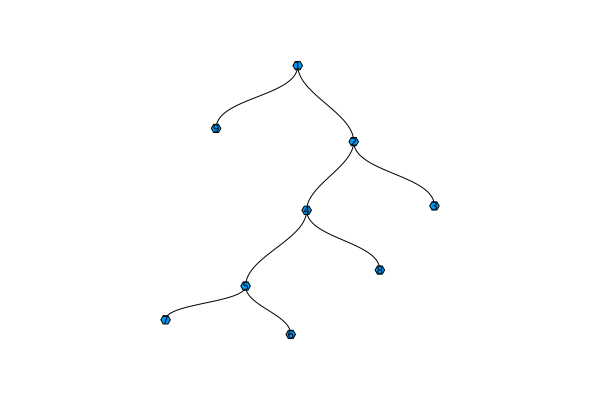

In [7]:
BestProfit, Bestsol, trParentnodes, trChildnodes, trNamenodes = SolveKnapInstance("instancesETU/KNAPnewformat/test.opb.txt", "borne1", true)
println("\n******\n\nOptimal value = ", BestProfit, "\n\nOptimal x=", Bestsol)
graphplot(trParentnodes, trChildnodes, names=trNamenodes, method=:tree)

In [9]:
Questions préliminares :

1. La règle de séparation permet de divisier une situation en deux cas à observer. Dans le programme donnée dans ce notebook, la règle de séparation 
fait qu'à chaque étude, le programme regarde si le premier objet non fixé (donc pas dans listobjs) doit être présent ou non (val = 1 ou val = 0).
Le programme parcours donc les objets dans leur ordre de présence


2. A chaque itération, la borne supérieure correspond au résultat (objectif) de la résolution du modèle linéaire (avec donc les valeurs comprises en 0 et 1, et ainsi
en flottant) en ayant fixé les objets déjà étudiés.

3. Le test d'admissibilité permet de vérifier que l'on respecte bien les contraintes. Dans le programme donné, on vérifie que la modèlisation
linéaire est faisable, qu'elle obtient bien une solution.
   Le test d'Optimalité permet de vérifier qu'un résultat réalisable est plus optimal qu'un autre résultat dejà calculé étant réalisable.
Dans le programme initiale, cet test correspond à vérifié si la borne supérieure est bien supérieure à un résultat réél (avec des valeurs entières)
déjà trouvé.
   Le test de résolution vérifie que la borne supérieur d'un état est égal à sa borne inférieur. Dans ce cas, cet état est la solution.

4. Pour la stratégie d'exploration, le programme de base explore d'abord le cas où l'objet est présent (val = 1). Lorsque le noeud n'est pas
sondable, on teste le noeud "voisin", lorsque l'objet n'est pas présent (val = 0). Et si ce noeud là n'est pas sondable, le programme remonte
au cas précédent pour analyser le cas précédent où l'objet n'est pas présent. Le programme remonte jusqu'à trouver une branche sondable ou arriver à la racine.

ErrorException: syntax: extra token "préliminares" after end of expression

In [10]:
BestProfit1, Bestsol1, trParentnodes, trChildnodes, trNamenodes1 = SolveKnapInstance("instancesETU/KNAPnewformat/strongly_correlated/knapPI_3_50_1000_1_-1894.opb.txt", "borne1",false)
println("\n******\n\nOptimal value = ", BestProfit1)
println("\nNombre de nodes pour la borne 1 : ",size(trNamenodes1))
BestProfit2, Bestsol2, trParentnodes, trChildnodes, trNamenodes2 = SolveKnapInstance("instancesETU/KNAPnewformat/strongly_correlated/knapPI_3_50_1000_1_-1894.opb.txt", "borne2",false)
println("\n******\n\nOptimal value = ", BestProfit2)
println("\nNombre de nodes pour la borne 2 : ",size(trNamenodes2))
println("\n\nProfit identique : ",BestProfit1==BestProfit2,"\nSolution identique : ",Bestsol1==Bestsol2)


******

Optimal value = 1894.0

Nombre de nodes pour la borne 1 : 

(2695,)

******

Optimal value = 1894.0

Nombre de nodes pour la borne 2 : (2315,)




Profit identique : true
Solution identique : true


In [12]:
BestProfit1, Bestsol1, trParentnodes, trChildnodes, trNamenodes1 = SolveKnapInstance("instancesETU/KNAPnewformat/similar_weights/knapPI_9_100_1000_2_-997.opb.txt", "borne1",false)
println("\n******\n\nOptimal value = ", BestProfit1)
println("\nNombre de nodes pour la borne 1 : ",size(trNamenodes1))
BestProfit2, Bestsol2, trParentnodes, trChildnodes, trNamenodes2 = SolveKnapInstance("instancesETU/KNAPnewformat/similar_weights/knapPI_9_100_1000_2_-997.opb.txt", "borne2",false)
println("\n******\n\nOptimal value = ", BestProfit2)
println("\nNombre de nodes pour la borne 2 : ",size(trNamenodes2))
println("\n\nProfit identique : ",BestProfit1==BestProfit2,"\nSolution identique : ",Bestsol1==Bestsol2)


******

Optimal value = 997.0

Nombre de nodes pour la borne 1 : (20029,)

******

Optimal value = 

997.0

Nombre de nodes pour la borne 2 : (20027,)


Profit identique : true
Solution identique : true


In [31]:
BestProfit1, Bestsol1, trParentnodes, trChildnodes, trNamenodes1 = SolveKnapInstance("instancesETU/KNAPnewformat/weakly_correlated/knapPI_2_100_1000_1_-1514.opb.txt", "borne1",false)
println("\n******\n\nOptimal value = ", BestProfit1)
println("\nNombre de nodes pour la borne 1 : ",size(trNamenodes1))
BestProfit2, Bestsol2, trParentnodes, trChildnodes, trNamenodes2 = SolveKnapInstance("instancesETU/KNAPnewformat/weakly_correlated/knapPI_2_100_1000_1_-1514.opb.txt", "borne2",false)
println("\n******\n\nOptimal value = ", BestProfit2)
println("\nNombre de nodes pour la borne 2 : ",size(trNamenodes2))
println("\n\nProfit identique : ",BestProfit1==BestProfit2,"\nSolution identique : ",Bestsol1==Bestsol2)


******

Optimal value = 1514.0

Nombre de nodes pour la borne 1 : (3731,)

******

Optimal value = 

1514.0

Nombre de nodes pour la borne 2 : (3487,)


Profit identique : true
Solution identique : true


In [32]:
BestProfit1, Bestsol1, trParentnodes, trChildnodes, trNamenodes1 = SolveKnapInstance("instancesETU/KNAPnewformat/multiple_strongly_correlated/knapPI_14_50_1000_1_-2586.opb.txt", "borne1",false)
println("\n******\n\nOptimal value = ", BestProfit1)
println("\nNombre de nodes pour la borne 1 : ",size(trNamenodes1))
BestProfit2, Bestsol2, trParentnodes, trChildnodes, trNamenodes2 = SolveKnapInstance("instancesETU/KNAPnewformat/multiple_strongly_correlated/knapPI_14_50_1000_1_-2586.opb.txt", "borne2",false)
println("\n******\n\nOptimal value = ", BestProfit2)
println("\nNombre de nodes pour la borne 2 : ",size(trNamenodes2))
println("\n\nProfit identique : ",BestProfit1==BestProfit2,"\nSolution identique : ",Bestsol1==Bestsol2)


******

Optimal value = 2586.0

Nombre de nodes pour la borne 1 : (303,)

******

Optimal value = 2586.0

Nombre de nodes pour la borne 2 : (185,)


Profit identique : true
Solution identique : true


In [33]:
BestProfit1, Bestsol2, trParentnodes, trChildnodes, trNamenodes1 = SolveKnapInstance("instancesETU/KNAPnewformat/circle/knapPI_16_50_1000_1_-3408.opb.txt", "borne1",false)
println("\n******\n\nOptimal value = ", BestProfit1)
println("\nNombre de nodes pour la borne 1 : ",size(trNamenodes1))
BestProfit2, Bestsol2, trParentnodes, trChildnodes, trNamenodes2 = SolveKnapInstance("instancesETU/KNAPnewformat/circle/knapPI_16_50_1000_1_-3408.opb.txt", "borne2",false)
println("\n******\n\nOptimal value = ", BestProfit2)
println("\nNombre de nodes pour la borne 2 : ",size(trNamenodes2))
println("\n\nProfit identique : ",BestProfit1==BestProfit2,"\nSolution identique : ",Bestsol1==Bestsol2)


******

Optimal value = 3408.0

Nombre de nodes pour la borne 1 : (325,)

******

Optimal value = 3408.0

Nombre de nodes pour la borne 2 : (201,)


Profit identique : true
Solution identique : false


In [45]:
BestProfit1, Bestsol2, trParentnodes, trChildnodes, trNamenodes1 = SolveKnapInstance("instancesETU/KNAPnewformat/inverse_strongly_correlated/knapPI_4_50_1000_5_-1278.opb.txt", "borne1",false)
println("\n******\n\nOptimal value = ", BestProfit1)
println("\nNombre de nodes pour la borne 1 : ",size(trNamenodes1))
BestProfit2, Bestsol2, trParentnodes, trChildnodes, trNamenodes2 = SolveKnapInstance("instancesETU/KNAPnewformat/inverse_strongly_correlated/knapPI_4_50_1000_5_-1278.opb.txt", "borne2",false)
println("\n******\n\nOptimal value = ", BestProfit2)
println("\nNombre de nodes pour la borne 2 : ",size(trNamenodes2))
println("\n\nProfit identique : ",BestProfit1==BestProfit2,"\nSolution identique : ",Bestsol1==Bestsol2)


******

Optimal value = 1280.0

Nombre de nodes pour la borne 1 : (18357,)

******

Optimal value = 

1280.0

Nombre de nodes pour la borne 2 : (18357,)


Profit identique : true
Solution identique : false


In [46]:
BestProfit1, Bestsol2, trParentnodes, trChildnodes, trNamenodes1 = SolveKnapInstance("instancesETU/KNAPnewformat/circle/knapPI_16_100_1000_1_-4400.opb.txt", "borne1",false)
println("\n******\n\nOptimal value = ", BestProfit1)
println("\nNombre de nodes pour la borne 1 : ",size(trNamenodes1))
BestProfit2, Bestsol2, trParentnodes, trChildnodes, trNamenodes2 = SolveKnapInstance("instancesETU/KNAPnewformat/circle/knapPI_16_100_1000_1_-4400.opb.txt", "borne2",false)
println("\n******\n\nOptimal value = ", BestProfit2)
println("\nNombre de nodes pour la borne 2 : ",size(trNamenodes2))
println("\n\nProfit identique : ",BestProfit1==BestProfit2,"\nSolution identique : ",Bestsol1==Bestsol2)


******

Optimal value = 4400.0

Nombre de nodes pour la borne 1 : (22079,)

******

Optimal value = 

4400.0

Nombre de nodes pour la borne 2 : (20395,)


Profit identique : true
Solution identique : false


In [47]:
La borne 2 donne une borne supérieur plus proche de la solution que la borne 1 car il n'ajoute que des objets entiers (sauf pour le dernier pour atteindre la 
quantité maximale) qui sont triés par ordre de rentabilité (prix/poids) comme pour le choix des objets étudiés à chaque noeuds. De ce fait, il est logique 
qu'avec la borne 2, on arrive plus rapidement à la solution optimale qu'avec la borne 1. Dans les 5 tests réalisés précédements, on peut observer qu'avec 
la borne 2, on obtient moins de noeuds qu'avec la borne 1 pour un même profit, ce qui indique une exécution théoriquement plus rapide car moins de tests, 
ni de calculs de bornes sont réalisés.
De plus, on peut remarquer dans les tests récupérés dans le dossier "circle", on obtient des solutions différentes pour des mêmes profits 
optimaux, ce qui montre que l'exécution est différente avec ces deux bornes.

Pour des raisons de temps de calcul, les tests avec des matrices

ErrorException: syntax: extra token "borne" after end of expression

In [48]:
BestProfit1, Bestsol2, trParentnodes, trChildnodes, trNamenodes1 = SolveKnapInstance("instancesETU/KNAPnewformat/almost_strongly_correlated/knapPI_5_50_10000_5_-22000.opb.txt", "borne1",false)
println("\n******\n\nOptimal value = ", BestProfit1)
println("\nNombre de nodes pour la borne 1 : ",size(trNamenodes1))
BestProfit2, Bestsol2, trParentnodes, trChildnodes, trNamenodes2 = SolveKnapInstance("instancesETU/KNAPnewformat/almost_strongly_correlated/knapPI_5_50_10000_5_-22000.opb.txt", "borne2",false)
println("\n******\n\nOptimal value = ", BestProfit2)
println("\nNombre de nodes pour la borne 2 : ",size(trNamenodes2))
println("\n\nProfit identique : ",BestProfit1==BestProfit2,"\nSolution identique : ",Bestsol1==Bestsol2)


******

Optimal value = 40986.0

Nombre de nodes pour la borne 1 : (1030173,)

******

Optimal value = 

40986.0

Nombre de nodes pour la borne 2 : (52389,)


Profit identique : true
Solution identique : false


In [70]:
println("\nNombre d'élément dans la solution borne 1 :",size(Bestsol1))
println("\nNombre d'élément dans la solution borne 2 :",size(Bestsol2))
price, weight, capacity = readKnaptxtInstance("instancesETU/KNAPnewformat/almost_strongly_correlated/knapPI_5_50_10000_5_-22000.opb.txt")
println("\nNombre d'élément dans le cas :",size(price))



Nombre d'élément dans la solution borne 1 :(23,)

Nombre d'élément dans la solution borne 2 :(250,)

Nombre d'élément dans le cas :(250,)


In [72]:
De plus, en appliquant certaines instances comme "almost_strongly_correlated", on obtient un profit plus obtimal que celui attendu par l'exemple. En effet,
dans le cas ci-dessus, on s'attend à avoir un profit de 22000 mais on obtient un proft de 40986. Ne sachant pas comment l'attente à été déterminer, il est 
compliqué de déterminer la cause. Mais au vu de la taille des solutions, on peut conclure que la borne 1 n'a pas abouti alors qu'elle renvoie un profit 
équivalent à la borne 2, qui elle semble avoir abouti.

ErrorException: syntax: extra token "plus" after end of expression

In [73]:
Nous n'avons pas pu essayer des tailles trop importantes car les temps de calculs étaient trop long, ce qui fait que pour certains cas, la différence entre 
la borne 1 et la borne 2 n'est pas flagrante à cause de la faible quantité de donnée.